In [187]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame

import torch
import torchvision
import torchvision.datasets as dsets             #for downloading dataset
import torchvision.transforms as transforms      #for transforming dataset into tensors

from torch import nn
from torch.autograd import Variable
import torchvision.transforms.functional as fn

from sklearn.model_selection import train_test_split

from time import time

import os
import timeit

## Import

In [188]:
data = pd.read_csv('double_pendulum_data.csv', sep=',')
display(data.iloc[[0, 11,22,33]])

data = data.to_numpy()

,theta_1,theta_2,dtheta_1,dtheta_2
0,2.041421,1.823328,-4.279792,-1.318959
11,0.121866,-2.937168,2.027835,-3.568434
22,2.178082,-0.079944,0.314733,-2.557206
33,0.594158,-2.375748,-2.819972,3.302232


## Train/Test

In [189]:
X_train, Y_train = data[0:1650,:], data[0:1650,:]
X_test, Y_test = data[1650:,:], data[1650:,:]


In [190]:
## converting to tensor 

x_train, y_train = torch.from_numpy(X_train).float().to(device), torch.from_numpy(Y_train).float().to(device)
x_test, y_test   = torch.from_numpy(X_test).float().to(device), torch.from_numpy(Y_test).float().to(device)

## Separate each sample

In [191]:
def separate_single_sample(x, y, sample_length):  ### separates each sample because our samples are stacked
    for batch, i in enumerate(range(0, len(x), sample_length)):
#         print('i:',i)
        x_batch = x[i : i + sample_length,:]
        y_batch = y[i : i + sample_length,:]      
        x_initial = x[i,:].reshape(1,4)
        yield x_batch, x_initial, y_batch, batch

## Define LSTM

In [192]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.input_size  = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm        = nn.LSTMCell(self.input_size, self.hidden_size)
        self.linear      = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, inputs, future, y=None):
        
        outputs = torch.tensor(np.zeros([10,4])).reshape(10,4)    ## Initialize output tensor 10 x 4 (t=1 to 10)
        
        # reset the state of LSTM
        h_t = torch.zeros(1, self.hidden_size, dtype=torch.float32).to(device)
        c_t = torch.zeros(1, self.hidden_size, dtype=torch.float32).to(device)

        input_t = inputs[0,:].reshape(1,4)
        h_t, c_t = self.lstm(input_t, (h_t, c_t))
        output   = self.linear(h_t)    ##output using initial condition
        outputs[0,:] = output


            
        for i in range(1, future):
            
            if y is not None and random.random() > 0.5:
                output = y[i,:].reshape(1,4)  # teacher forcing
                
            h_t, c_t = self.lstm(output, (h_t, c_t))
            output   = self.linear(h_t)
            
            outputs[i,:]   = output
        return outputs

## Hyperparameters

In [193]:
num_epochs     = 50
sample_length  = 11
lr             = 5e-3
lr_decay       = 0.75
decay_interval = 4
iteration      = 50

sample_length, decay_interval, iteration = map(int, [sample_length, decay_interval, iteration])
lr, lr_decay                          = map(float, [lr, lr_decay]) 

## Check if model works

In [194]:
model   = Model(4,200,4).to(device)

for x_batch, x_initial, y_batch, batch in separate_single_sample(x_train, y_train, sample_length):
    x_batch


prediction = model(x_batch.type(torch.float32), future=10, y=y_batch[:, :])
prediction = prediction.type(torch.float32)
print(len(prediction))


optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn   = nn.MSELoss()

optimizer.zero_grad()
loss = loss_fn(prediction, y_batch[1:,:])
loss.backward()
optimizer.step()


10


## Training

In [195]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn   = nn.MSELoss()

for epoch in range(num_epochs):
    train_loss = 0
    
    for x_batch, x_initial, y_batch, batch in separate_single_sample(x_train, y_train, sample_length):
        prediction = model(x_batch.type(torch.float32), future=10, y =y_batch[:, :])
        prediction = prediction.type(torch.float32)
#         print(prediction.shape)

        optimizer.zero_grad()
        loss = loss_fn(prediction, y_batch[1:,:])
        
        loss.backward()
        optimizer.step()
        
        train_loss = loss.item()
#     train_losses.append(train_loss)
    
    print('Batch: %d, \t Loss: %.4f ' %(epoch, train_loss))

        

Batch: 0, 	 Loss: 2.2344 
Batch: 1, 	 Loss: 1.7825 
Batch: 2, 	 Loss: 2.0588 
Batch: 3, 	 Loss: 1.8187 
Batch: 4, 	 Loss: 1.9825 
Batch: 5, 	 Loss: 1.6778 
Batch: 6, 	 Loss: 1.7933 
Batch: 7, 	 Loss: 1.8917 
Batch: 8, 	 Loss: 2.4332 
Batch: 9, 	 Loss: 2.0262 
Batch: 10, 	 Loss: 6.8452 
Batch: 11, 	 Loss: 1.8487 
Batch: 12, 	 Loss: 1.8795 
Batch: 13, 	 Loss: 1.7196 
Batch: 14, 	 Loss: 2.1451 
Batch: 15, 	 Loss: 2.1967 
Batch: 16, 	 Loss: 2.4798 
Batch: 17, 	 Loss: 2.0792 
Batch: 18, 	 Loss: 2.2075 
Batch: 19, 	 Loss: 2.0801 
Batch: 20, 	 Loss: 2.2183 
Batch: 21, 	 Loss: 1.8913 
Batch: 22, 	 Loss: 1.6363 
Batch: 23, 	 Loss: 1.5751 
Batch: 24, 	 Loss: 2.0662 
Batch: 25, 	 Loss: 1.8423 
Batch: 26, 	 Loss: 1.8491 
Batch: 27, 	 Loss: 1.7309 
Batch: 28, 	 Loss: 1.7157 
Batch: 29, 	 Loss: 1.8763 
Batch: 30, 	 Loss: 2.0287 
Batch: 31, 	 Loss: 1.7590 
Batch: 32, 	 Loss: 2.0891 
Batch: 33, 	 Loss: 1.8896 
Batch: 34, 	 Loss: 2.0163 
Batch: 35, 	 Loss: 1.9804 
Batch: 36, 	 Loss: 1.6391 
Batch: 37, 

## Test

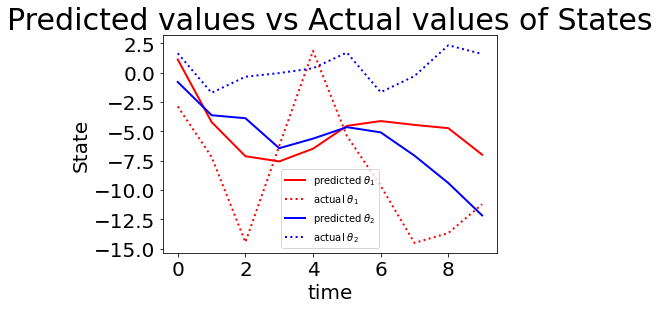

Batch 0 	 Loss: 49.8647


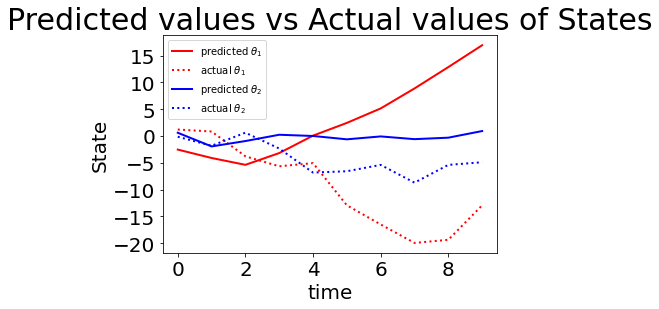

Batch 1 	 Loss: 118.8080


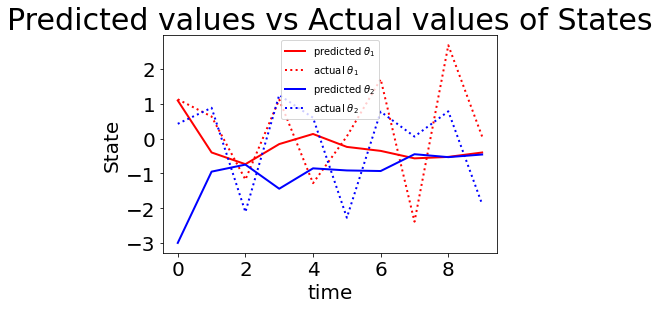

Batch 2 	 Loss: 11.7621


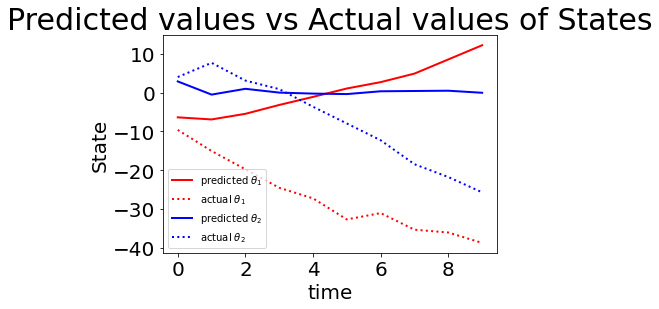

Batch 3 	 Loss: 330.9745


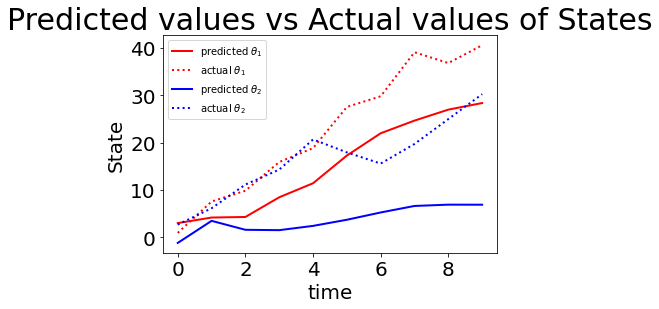

Batch 4 	 Loss: 86.9629


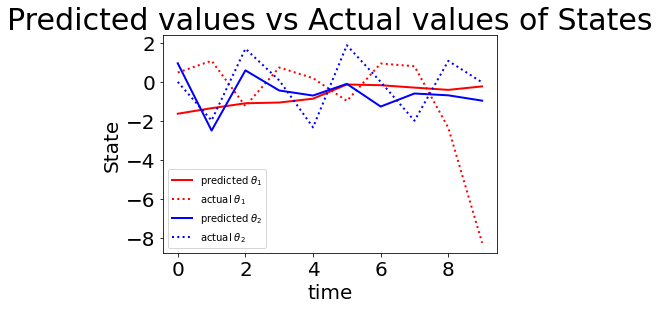

Batch 5 	 Loss: 11.5347


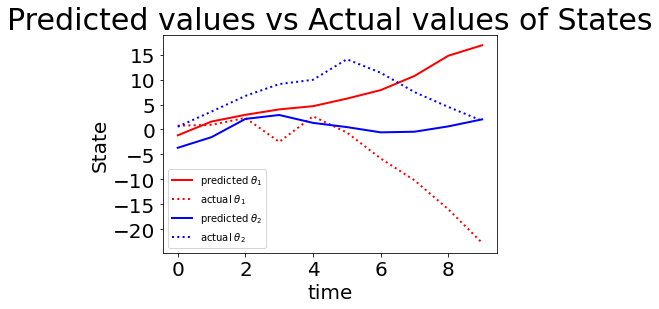

Batch 6 	 Loss: 108.2315


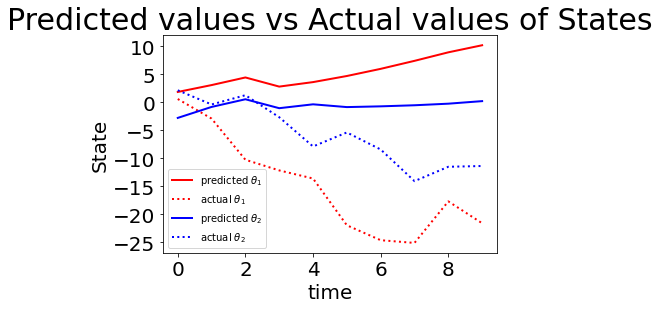

Batch 7 	 Loss: 170.9803


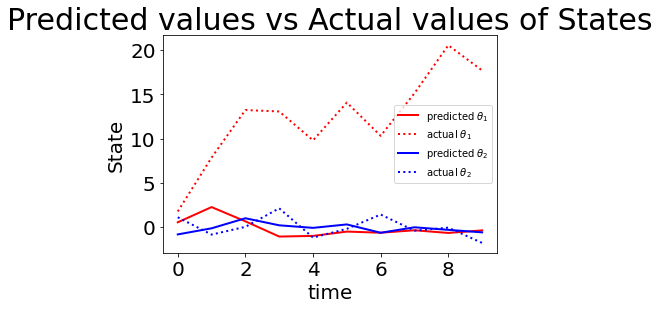

Batch 8 	 Loss: 57.8456


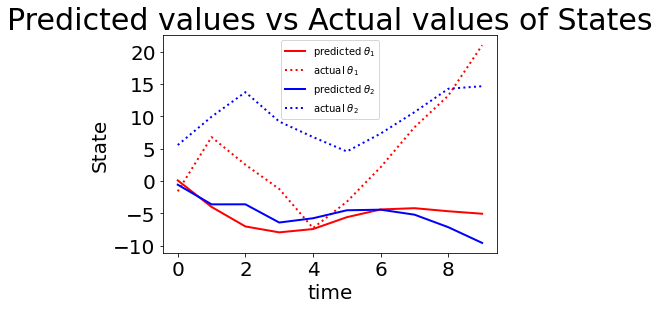

Batch 9 	 Loss: 120.3730


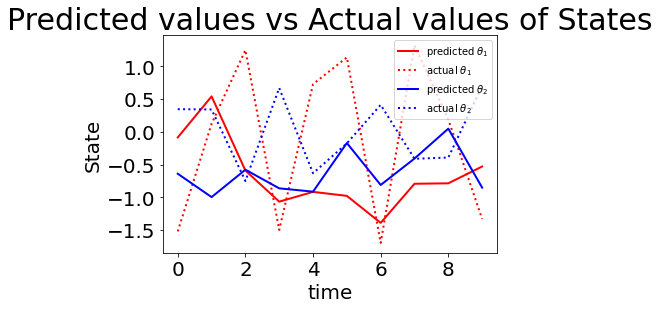

Batch 10 	 Loss: 9.8494


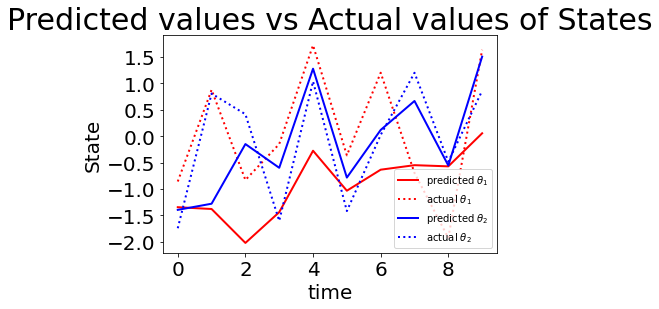

Batch 11 	 Loss: 6.1946


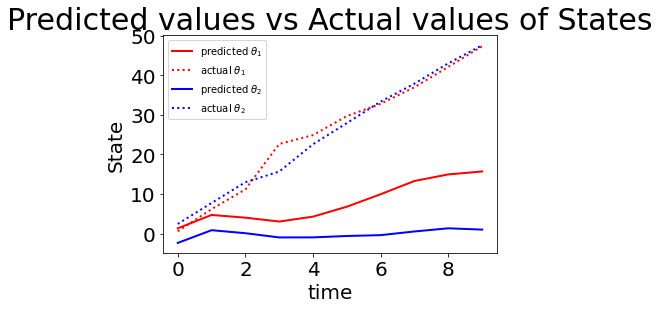

Batch 12 	 Loss: 328.7486


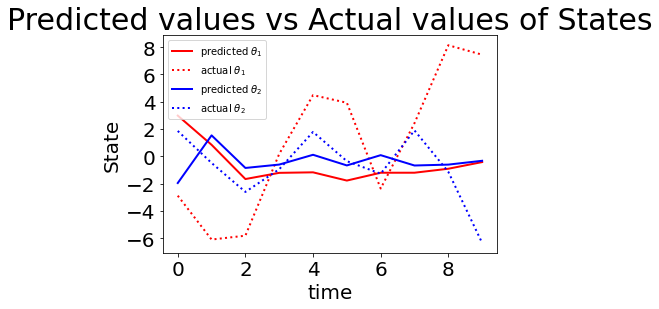

Batch 13 	 Loss: 26.3843


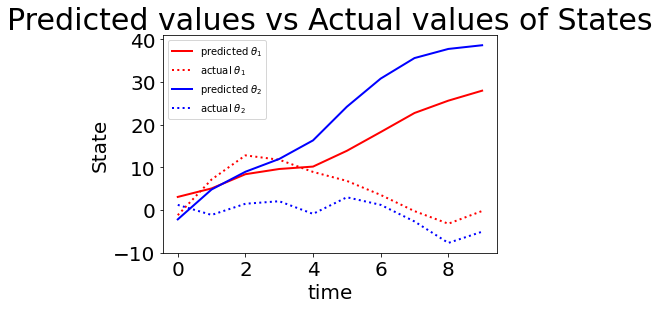

Batch 14 	 Loss: 264.2653


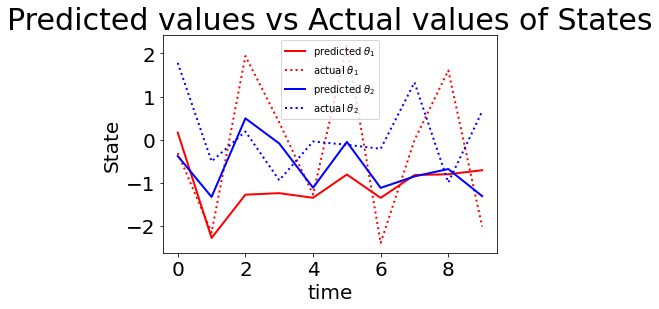

Batch 15 	 Loss: 6.7342


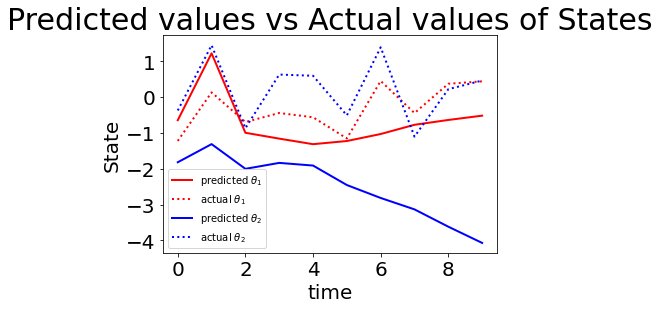

Batch 16 	 Loss: 5.6373


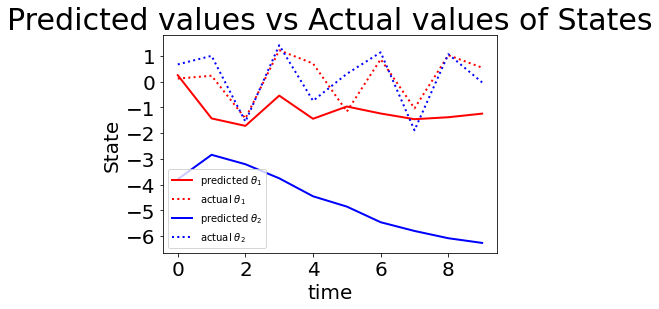

Batch 17 	 Loss: 20.4042


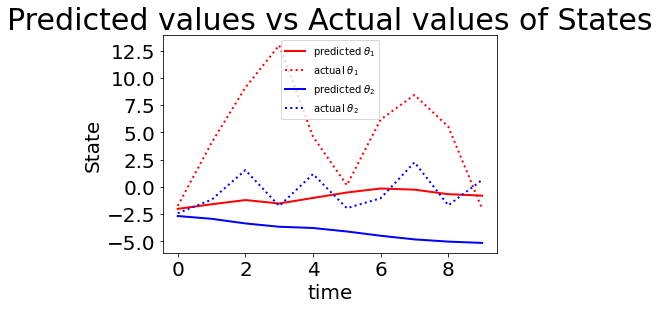

Batch 18 	 Loss: 35.1000


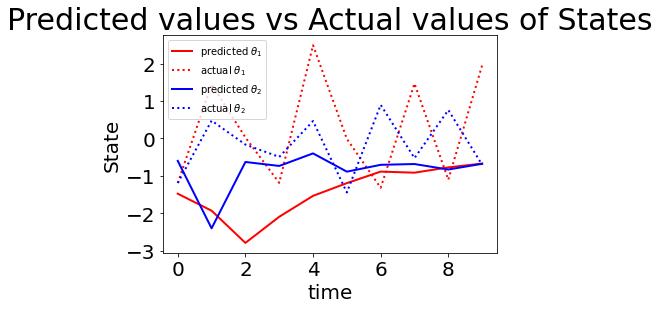

Batch 19 	 Loss: 18.3867


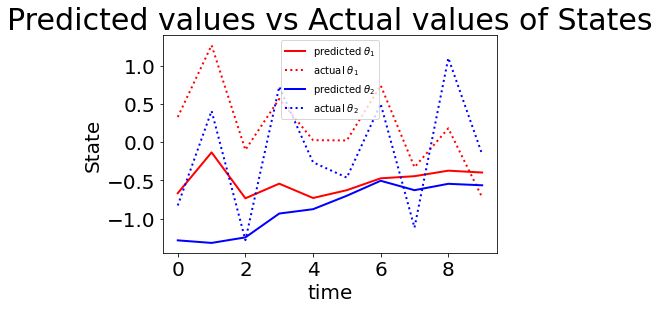

Batch 20 	 Loss: 6.2501


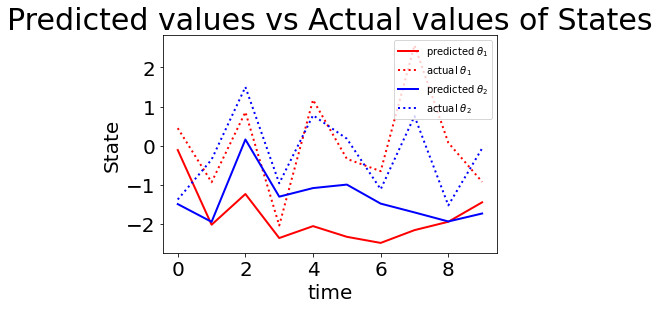

Batch 21 	 Loss: 15.1209


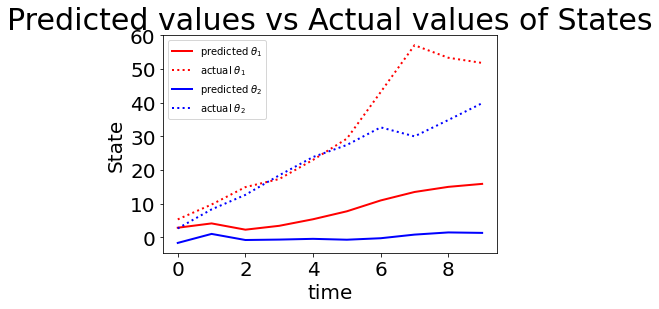

Batch 22 	 Loss: 365.8654


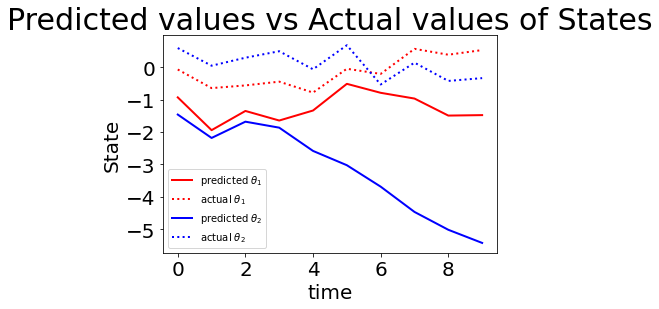

Batch 23 	 Loss: 5.8881


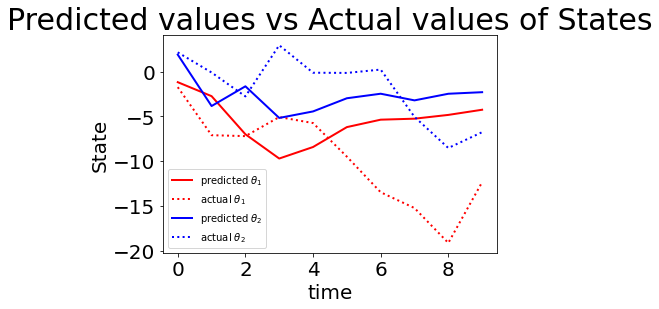

Batch 24 	 Loss: 33.9633


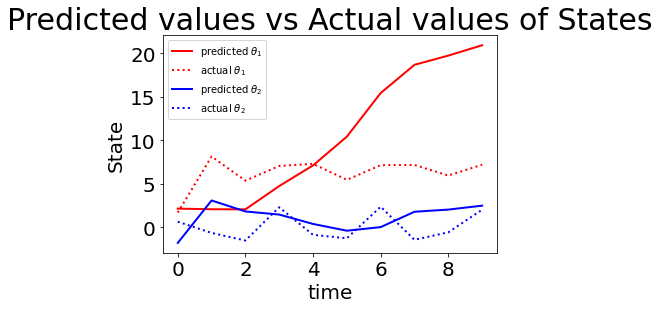

Batch 25 	 Loss: 25.6729


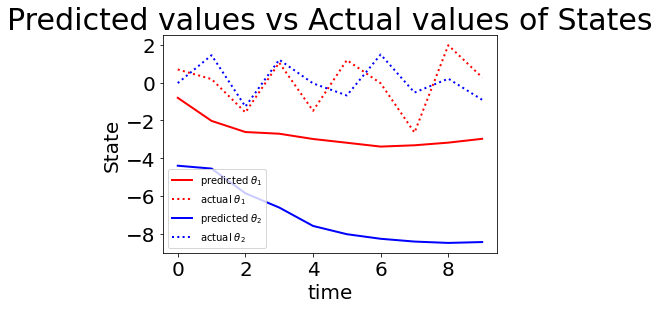

Batch 26 	 Loss: 24.1444


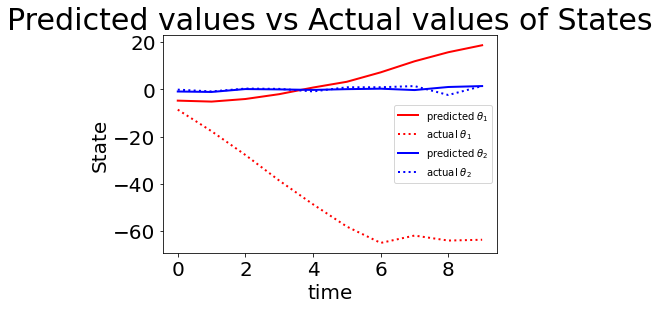

Batch 27 	 Loss: 832.5200


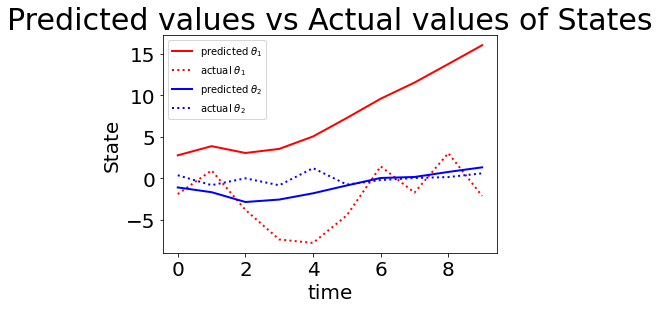

Batch 28 	 Loss: 38.7502


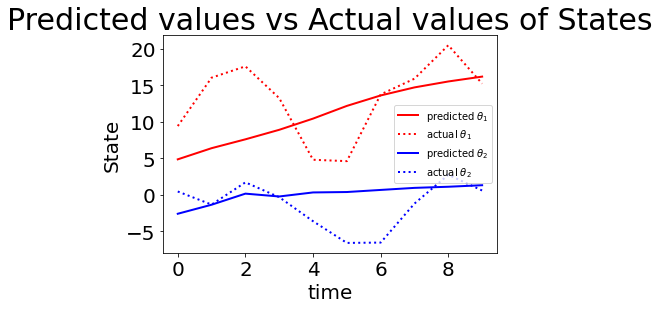

Batch 29 	 Loss: 32.4338


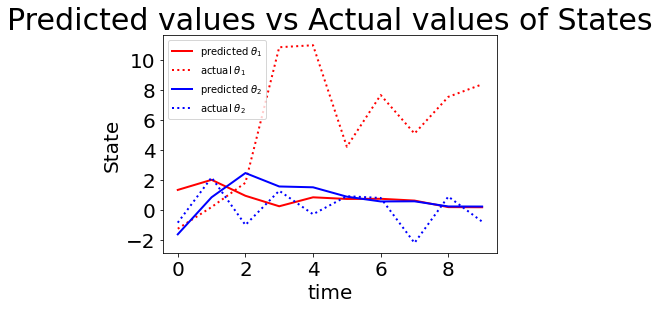

Batch 30 	 Loss: 28.5658


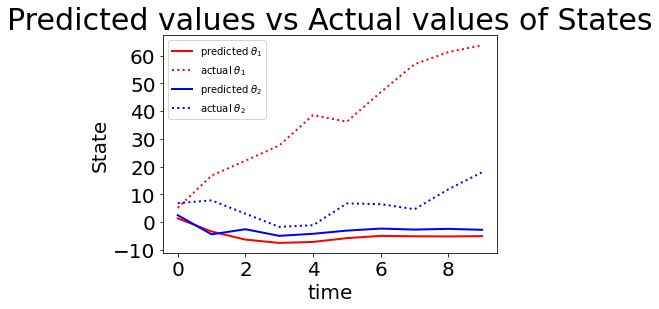

Batch 31 	 Loss: 599.5748


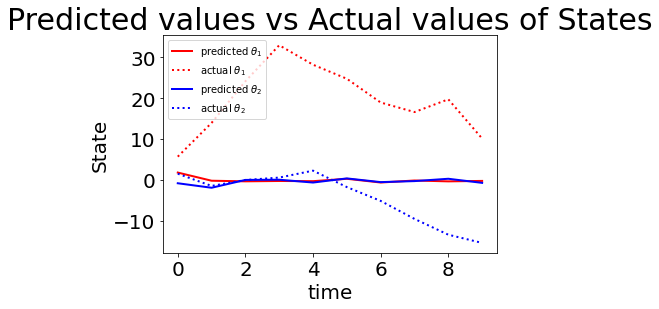

Batch 32 	 Loss: 151.9905


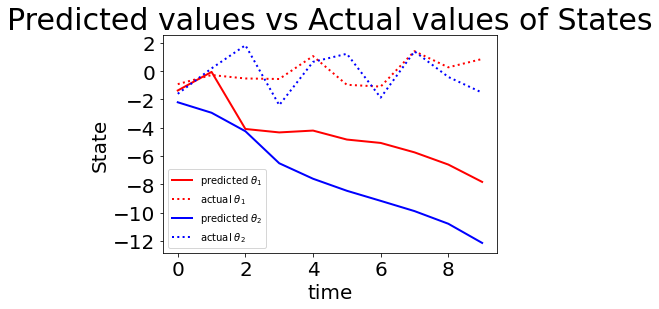

Batch 33 	 Loss: 29.3919


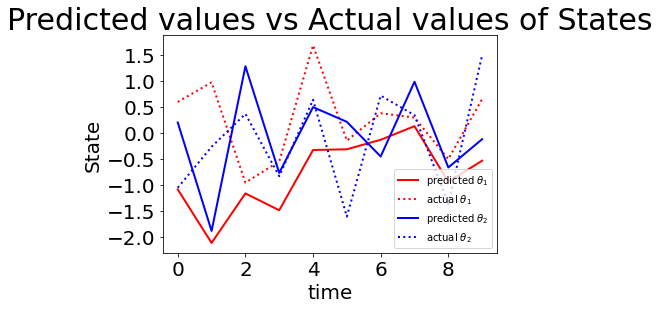

Batch 34 	 Loss: 8.2039


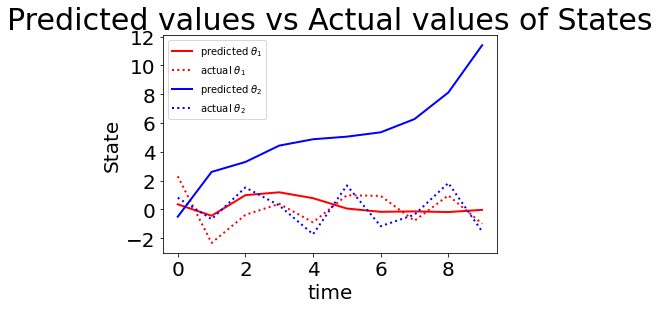

Batch 35 	 Loss: 15.8898


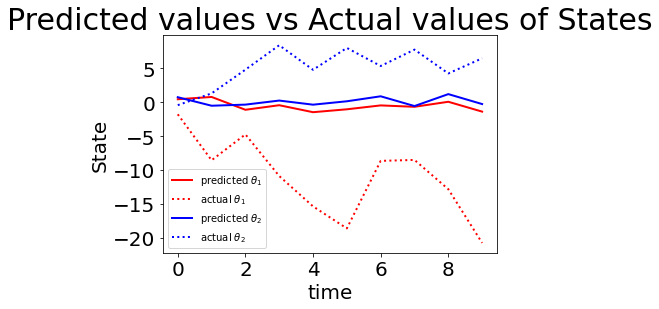

Batch 36 	 Loss: 63.1350


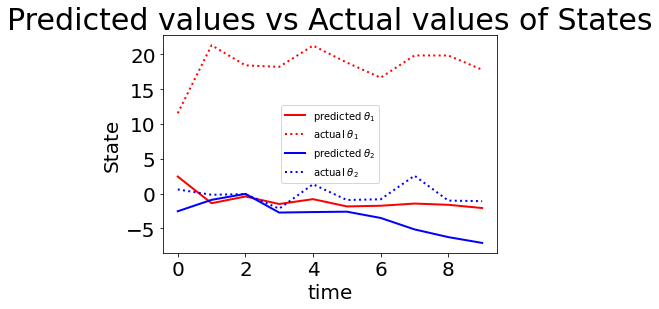

Batch 37 	 Loss: 116.6534


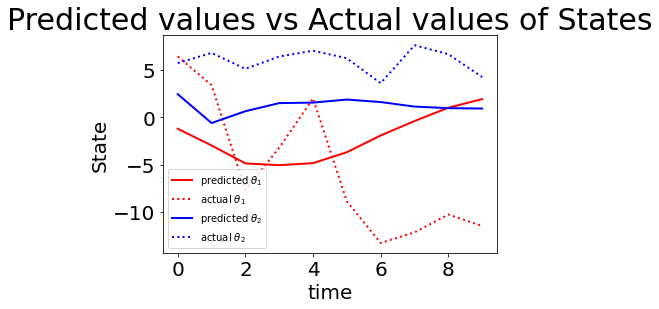

Batch 38 	 Loss: 52.0352


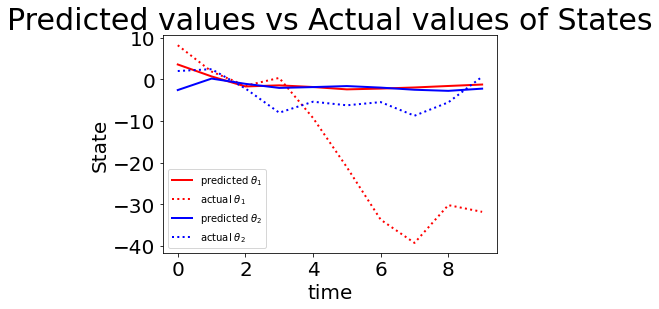

Batch 39 	 Loss: 153.0599


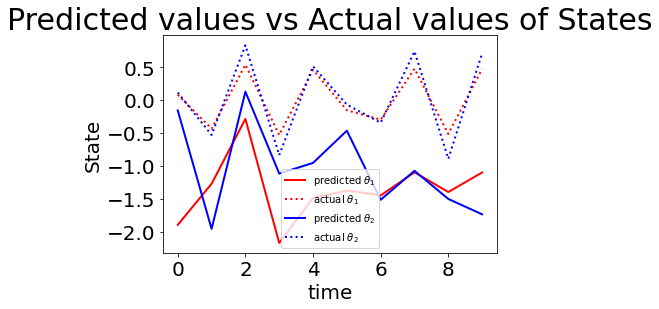

Batch 40 	 Loss: 2.1669


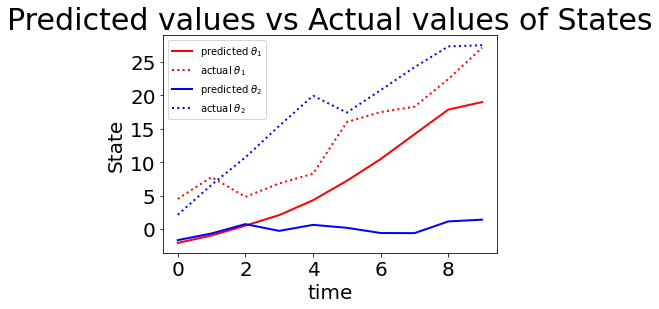

Batch 41 	 Loss: 114.1007


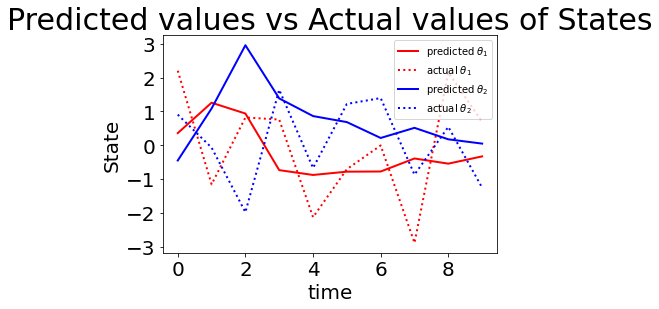

Batch 42 	 Loss: 7.2240


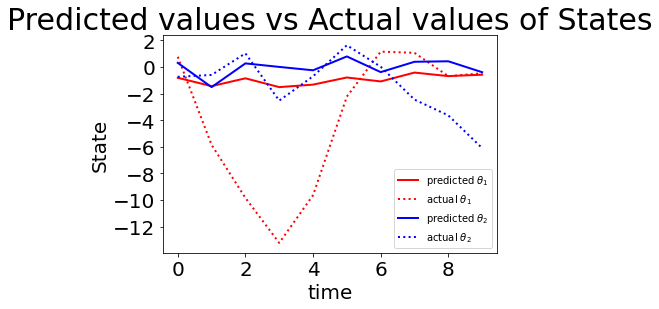

Batch 43 	 Loss: 18.8527


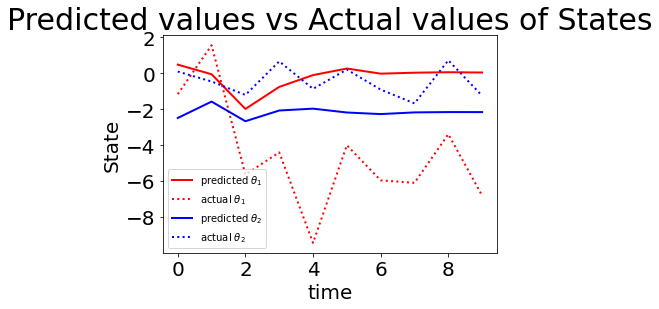

Batch 44 	 Loss: 16.0646


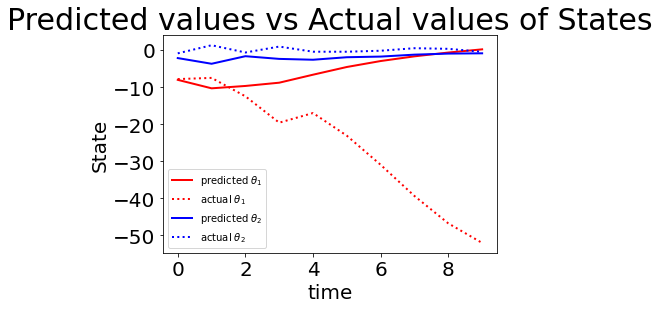

Batch 45 	 Loss: 218.3052


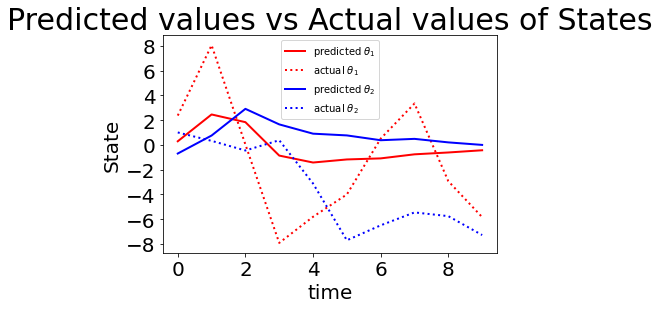

Batch 46 	 Loss: 26.3826


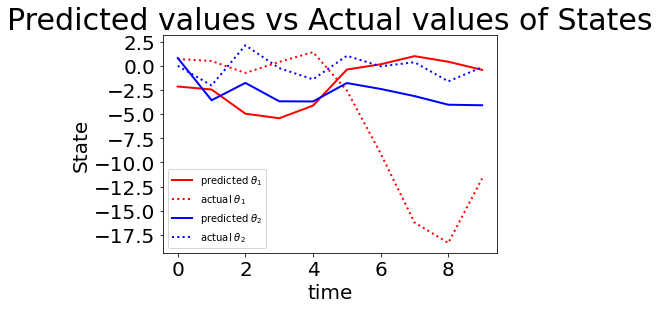

Batch 47 	 Loss: 38.3729


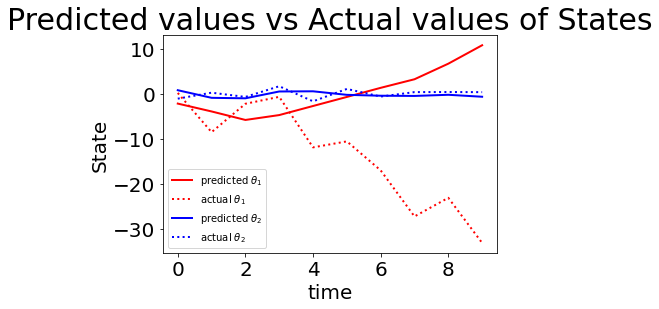

Batch 48 	 Loss: 133.0670


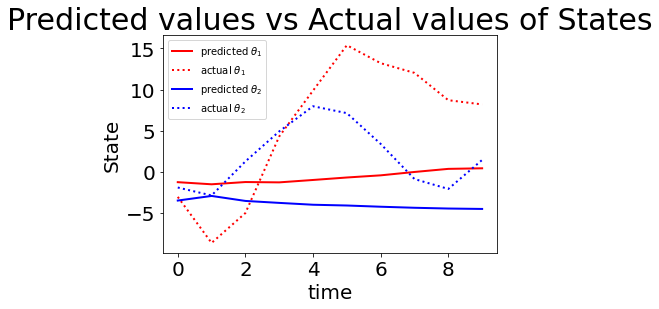

Batch 49 	 Loss: 57.9713


In [196]:
for x_batch, x_initial, y_batch, batch in separate_single_sample(x_test, y_test, sample_length):
    
    test_prediction = model(x_batch.type(torch.float32), future=10, y =None) ## y=None predicts only based on initial
    test_prediction = test_prediction.type(torch.float32)
    loss = loss_fn(test_prediction, y_batch[1:,:])
    
    prediction = test_prediction.detach().numpy()
    label = y_batch.detach().numpy()

    plt.figure()
    plt.title('Predicted values vs Actual values of States', fontsize=30)
    plt.xlabel('time', fontsize=20)
    plt.ylabel('State', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.plot(prediction[:,0], 'r',label=r'predicted $\theta_1$', linewidth = 2.0)
    plt.plot(label[1:,0] , 'r' + ':', label=r'actual $\theta_1$', linewidth = 2.0)
    plt.plot(prediction[:,1], 'b',label=r'predicted $\theta_2$', linewidth = 2.0)
    plt.plot(label[1:,1] , 'b' + ':', label=r'actual $\theta_2$', linewidth = 2.0)
    plt.legend()
    plt.show()                                         ### view plots
#     plt.savefig('figures/predicted vs actual%d.png' %batch, dpi=72)  ### save plots
    plt.close()

        
    test_loss = loss.item()
    print('Batch %d \t Loss: %.4f'%(batch, test_loss))
# train_losses.append(train_loss)